## Курс «Симулятор Аналитика», поток 31<br><br>Студент А. Ионочкин<br>

## Урок 4, Домашнее задание №1

Есть данные А/А-теста. Необходимо убедиться в том, что наша система сплитования работает корректно, и _ключевая метрика_ не отличается между группами не только в конкретно нашем А/А-тесте, но и в целом.  (Судя по тому, что в лекции в качестве "ключевой метрики" мы работали с CTR, предположим, что в домашнем задании также речь идёт о CTR, хотя, в явном виде об этом не сказано ))  ) 

Даты проведения А/А-теста: с '2024-04-26' по '2024-05-02'

Испытуемые:  группы 2 и 3

Необходимо сделать симуляцию 10000 А/А-тестов: на каждой итерации сформировать подвыборки без повторения размером в 500 юзеров; провести сравнение этих подвыборок t-testом; полученные данные - визуализировать и проанализировать. 

In [50]:
# import pandas as pd 

import pandahouse

In [51]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20240520'
}

In [52]:
q = '''

SELECT
    exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes / views as CTR
FROM {db}.feed_actions 
WHERE toDate(time) between '2024-04-26' AND '2024-05-02' 
    AND exp_group in (2,3)
GROUP BY exp_group, user_id

'''


df = pandahouse.read_clickhouse(q, connection = connection)

df.head(10)

exp_group  user_id  likes  views       CTR
0          3   115383     38    248  0.153226
1          3    10326     24    132  0.181818
2          3   123580     25    122  0.204918
3          2   131473     19     98  0.193878
4          2    23985     12     44  0.272727
5          2    24523      2     10  0.200000
6          2    24239     10     41  0.243902
7          3    19647      4     31  0.129032
8          2   127588     14     87  0.160920
9          2     6911     17    117  0.145299

## Посмотрели глазками, как выглядят наши сэмплы в табличке и на графике: 

In [53]:
sample_example = df.groupby('exp_group', group_keys = False).apply(lambda x: x.sample(500))

sample_example

exp_group  user_id  likes  views       CTR
2245           2    15530     25    100  0.250000
15345          2    15676     22     97  0.226804
7904           2    21243     20    105  0.190476
1643           2   131758     15     77  0.194805
4723           2   120765     25    151  0.165563
...          ...      ...    ...    ...       ...
8150           3   108828     20    150  0.133333
9557           3   128778     18     92  0.195652
10814          3   115799      8     49  0.163265
12378          3   112041      6     37  0.162162
7820           3   123965     12     52  0.230769

[1000 rows x 5 columns]

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(rc = {'figure.figsize':(12, 9)})

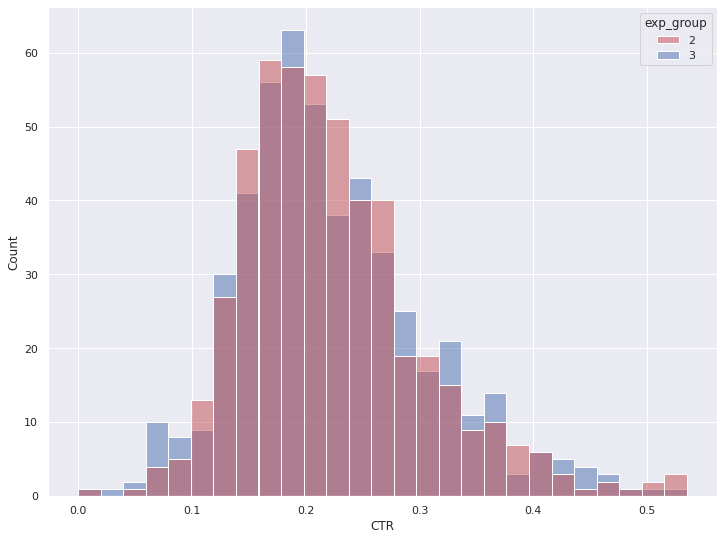

In [55]:
plot_ = sns.histplot(data = sample_example, x = 'CTR', hue = 'exp_group', palette = ['r', 'b'], alpha = 0.5)

In [56]:
import scipy.stats as ss

In [57]:
# ...а также проведём единичный т-тест и посмотрим, что он показывает: 

tt = ss.ttest_ind(sample_example[sample_example.exp_group == 2].CTR, sample_example[sample_example.exp_group == 3].CTR, equal_var = False)

# парам. equal_var = False говорит тесту, что дисперсии могут различаться 

print('p-value = ', tt[1])

p-value =  0.9782508586526083


  -- сэмплы сэмплируются, данные сравниваются, т-тест выдаёт рандомные p-value

## Запускаем симулякр: 

In [58]:
n = 10000 # число итераций

p_values = []  # список для хранения p-values

# делаем n подвыборок, сравниваем и пишем p-values в массив: 

for i in range(n):
    smpl = df.groupby('exp_group', group_keys = False).apply(lambda x: x.sample(500))
    tt = ss.ttest_ind(smpl[smpl.exp_group == 2].CTR, smpl[smpl.exp_group == 3].CTR, equal_var = False)
    p_values.append(tt[1])

In [59]:
# проверяем, что сгенерилось ровно n значений: 

len(p_values)

10000

## Задание 1.1 - Гистограмма распределения p-value:

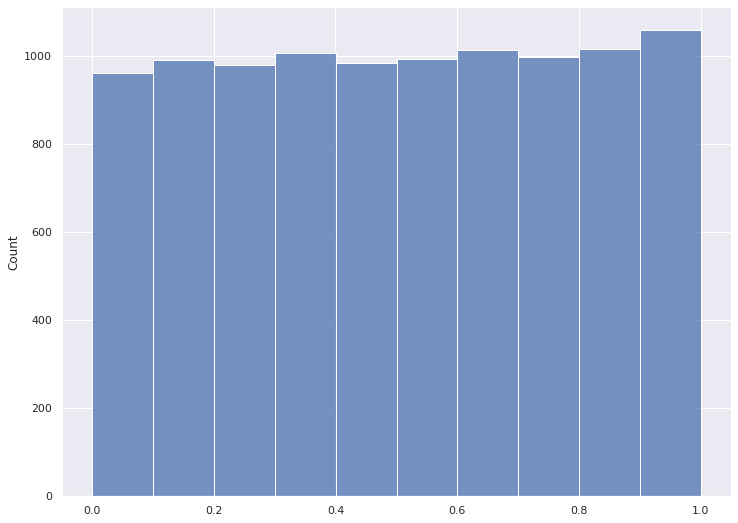

In [60]:
plot_p_values = sns.histplot(p_values, bins = 10)

-- значения p-value распределились равномерно 

## Задание 1.2 - вычисление доли p-value <= 0.05:

In [61]:
import numpy as np

In [62]:
a = np.asarray(p_values)

b = a[a <= .05]

print('В', len(b) / len(a) * 100, '% случаев мы можем получить значение p-value, позволяющее отклонить гипотезу H0 об отсутсвии различий между сэмплами')

В 4.6 % случаев мы можем получить значение p-value, позволяющее отклонить гипотезу H0 об отсутсвии различий между сэмплами


---

## Выводы: 

В проведенном тесте доля случаев, когда p-value был меньше или равен 0.05, равна 0,046.  Так как эта величина не превышает порогового значения в 5%, мы можем предположить, что выбранные группы 2 и 3 не имеют статистически значимых различий, следовательно, система сплитования работает корректно.